In [82]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

##### Download the data

In [4]:
data = fetch_20newsgroups()

##### Inspect the data

In [7]:
[k for k in data.keys()]

['data', 'filenames', 'target_names', 'target', 'DESCR']

In [10]:
[k for k in data['data']][0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [12]:
[t for t in data['target_names']]

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

##### Clean the data

In [53]:
# Dividing the text into sentences and storing them as a list of strings.

X = pd.Series([d for d in data.data])

import gensim
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import bigrams

STEMMER = SnowballStemmer("english", ignore_stopwords=True)

def preprocess(text: pd.Series, *args):
    text = text.apply(gensim.utils.simple_preprocess, min_len=3)
    sw = set(stopwords.words('english'))

    text = text.apply(lambda s: [w for w in s if w not in sw])
    text = text.apply(lambda s: [STEMMER.stem(w) for w in s])
    text = text.apply(lambda s: ['_'.join(x) for x in nltk.bigrams(s)] + s)
    text = text.apply(lambda s: [w.lower() for w in s])

    return text

#X_clean = [preprocess(x) for x in X]

X_clean[0]

"From: lerxst@wam.umd.edu (where's my thing) Subject: WHAT car is this!? Nntp-Posting-Host: rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: 15 I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is all I know. If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail. Thanks, - IL brought to you by your neighborhood Lerxst"

##### make the TFIDF matrix

In [67]:
# Creating the tf-idf matrix.
tf_idf = TfidfVectorizer(lowercase=True, 
                         preprocessor=True,
                         stop_words='english',
                         strip_accents=True,
                         ngram_range=(1, 1), 
                         analyzer=u'word', 
                         max_df=.5, 
                         min_df=1,
                         max_features=None, 
                         vocabulary=None, 
                         binary=False)

#Applying the vectorizer
tf_idf_news=counter.fit_transform(X_clean)

In [68]:
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
news_groups_lsa = lsa.fit_transform(tf_idf_news)

# Getting the word list.
terms = counter.get_feature_names()

# Loading scores for each word on each topic/component.
words_by_topic=tf_idf_news.T * news_groups_lsa

# Linking the loadings to the words in an easy-to-read way.
components=pd.DataFrame(words_by_topic,index=terms)

##### Cluster with KMEANS

In [78]:
kmeans_20 = KMeans(n_clusters=len(data.target_names), n_init=1).fit(tf_idf_news)

In [80]:
# dimensionality reduction from 20 to 2 
newsgroups_2d = TruncatedSVD(n_components = 2).fit_transform(tf_idf_news)

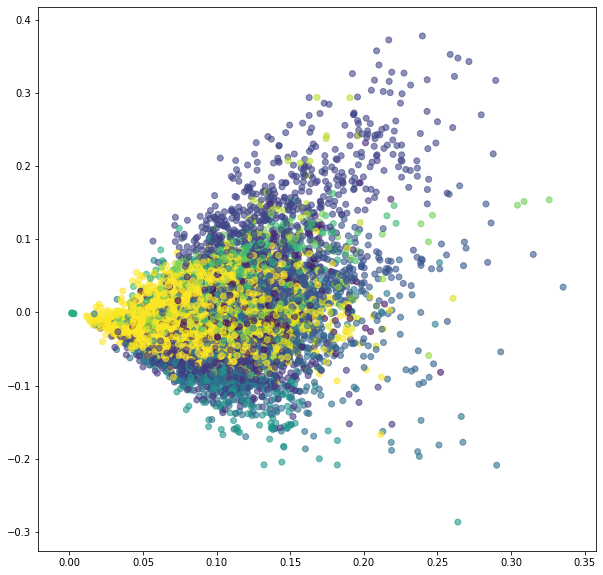

In [84]:
# display 20 clusters
plt.figure(figsize = (10, 10))
plt.scatter(newsgroups_2d[:,0], newsgroups_2d[:,1], c=kmeans_20.labels_, alpha=0.6)
plt.show()

##### Look at 5 topics with LSA & NMF

In [99]:
ntopics = 5

def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=[x for x in chosenlist]
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10

In [100]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
news_lsa = lsa.fit_transform(tf_idf_news)

components_lsa = word_topic(tf_idf_news, news_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                


In [109]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
news_nmf = nmf.fit_transform(tf_idf_news) 

components_nmf = word_topic(tf_idf_news, news_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

In [110]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                 LSA             NNMF
0         com 214.97     windows 3.97
0      article 120.2         com 3.38
0  university 108.92       drive 2.73
0         don 103.51        scsi 2.54
0      posting 102.5        card 2.31
0        like 102.09  university 2.21
0        just 100.74         use 2.16
0       people 98.41         dos 2.07
0         host 97.84     posting 2.04
0         nntp 96.97        host 2.02
Topic 1:
                LSA             NNMF
1         god 54.53         god 10.7
1      people 28.79       jesus 4.78
1       jesus 25.55       people 3.8
1    christian 16.9       bible 3.02
1       bible 16.68    christian 2.8
1  christians 16.21     believe 2.75
1     believe 14.37  christians 2.67
1        jews 14.16       faith 2.39
1      israel 13.24         don 2.39
1      christ 13.14       think 2.36
Topic 2:
                LSA             NNMF
2         key 32.15         key 5.61
2     clipper 26.26  encryption 4.59
2  encryption 24.97     clipper 4.41


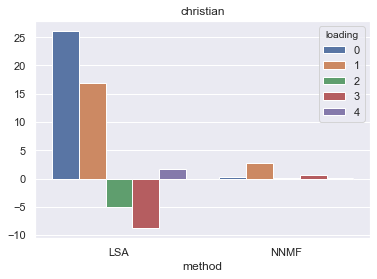

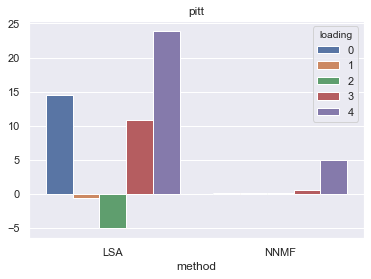

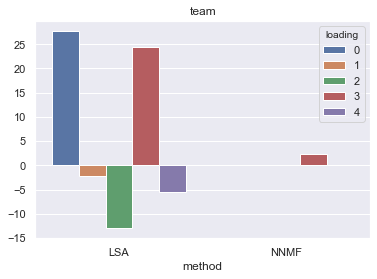

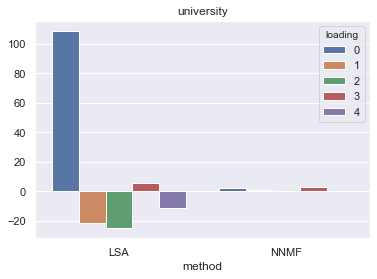

In [118]:
import seaborn as sns

# The words to look at.
targetwords=['christian','pitt','team','university']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*2

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()